# Import the required libraries

In [1]:
!pip install pyspark
!pip install confluent-kafka
!pip install Faker

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from faker import Faker
import random
from confluent_kafka import Producer
import json
import time
import glob

## 1 : Python program for customer segmentation with sample input and outputs 

In [3]:
data = pd.read_csv('pizza_customers.csv')
data

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [4]:
data.columns
data.rename(columns = {'Spending Score (1-100)':'Spending Score'}, inplace = True)
data.rename(columns = {'Annual Income (k$)':'Annual Income'}, inplace = True)


In [5]:
data.drop(data.columns[[0,1]], axis=1, inplace=True)
data

,Age,Annual Income,Spending Score
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40
...,...,...,...
195,35,120,79
196,45,126,28
197,32,126,74
198,32,137,18


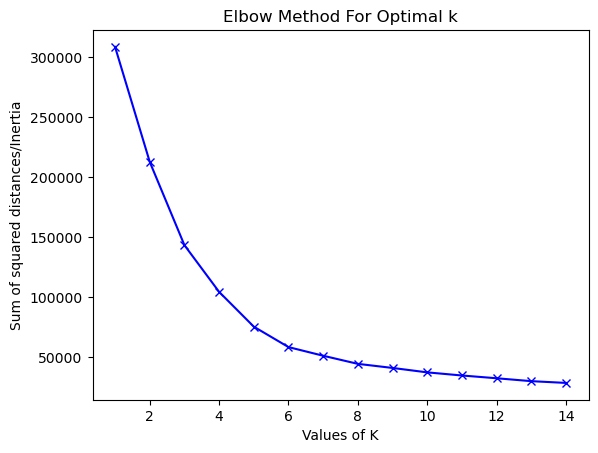

In [6]:
Sum_of_squared_distances = []
K = range(1,15)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(data)
    Sum_of_squared_distances.append(kmeans.inertia_)

plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K')
plt.ylabel('Sum of squared distances/Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

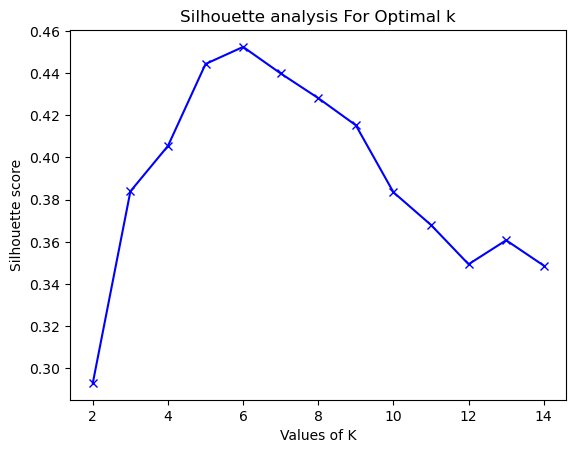

In [7]:
range_n_clusters = range(2,15)
silhouette_avg = []
for num_clusters in range_n_clusters:
      kmeans = KMeans(n_clusters=num_clusters)
      kmeans.fit(data)
      cluster_labels = kmeans.labels_
      silhouette_avg.append(silhouette_score(data, cluster_labels))
plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k')
plt.show()

Considering elbow and silhouette we consider k=6

**Considering KMeans takes centroid at random, we will be implementing it, re-running the below program will result in different clusters and centroids**

In [8]:
class KMeans:
    def __init__(self, n_clusters=6, max_iters=100):
        self.n_clusters = n_clusters
        self.max_iters = max_iters

    def fit(self, data):
        # Extract the variables from the DataFrame
        X = data.values

        # Initialize centroids randomly from data points
        centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]

        cluster_data = {}

        for iteration in range(self.max_iters):
            # Assign each data point to the nearest centroid
            labels = self._assign_labels(X, centroids)

            # Update centroids
            new_centroids = self._update_centroids(X, labels)

            # Check for convergence
            if np.all(centroids == new_centroids):
                break

            centroids = new_centroids

            # Store cluster data
            cluster_data = self._get_cluster_data(data, labels)

        self.labels_ = labels
        self.cluster_centers_ = centroids
        self.cluster_data_ = cluster_data

    def _assign_labels(self, X, centroids):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        return labels

    def _update_centroids(self, X, labels):
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(self.n_clusters)])
        return new_centroids

    def _get_cluster_data(self, data, labels):
        cluster_data = {}
        for cluster in range(self.n_clusters):
            cluster_indices = np.where(labels == cluster)[0]
            cluster_data[cluster] = data.iloc[cluster_indices]
        return cluster_data

# Example usage with a DataFrame and 4 clusters based on multiple variables:
if __name__ == "__main__":

    # Instantiate and fit the custom K-means model with 4 clusters
    kmeans = KMeans(n_clusters=6)
    kmeans.fit(data)

    # Get cluster labels and cluster information
    labels = kmeans.labels_
    cluster_info = kmeans.cluster_data_

    print("\nCluster Information:")
    for cluster, data_df in cluster_info.items():
        num_records = len(data_df)
        centroid = kmeans.cluster_centers_[cluster]
        print(f"Cluster {cluster + 1}:")
        print(f"Centroid (Age,Income, Spending Score): {centroid}")
        print(f"Number of Records: {num_records}")
        print()



Cluster Information:
Cluster 1:
Centroid (Age,Income, Spending Score): [56.15555556 53.37777778 49.08888889]
Number of Records: 45

Cluster 2:
Centroid (Age,Income, Spending Score): [44.14285714 25.14285714 19.52380952]
Number of Records: 21

Cluster 3:
Centroid (Age,Income, Spending Score): [41.64705882 88.73529412 16.76470588]
Number of Records: 34

Cluster 4:
Centroid (Age,Income, Spending Score): [27.31578947 57.5        48.44736842]
Number of Records: 38

Cluster 5:
Centroid (Age,Income, Spending Score): [32.69230769 86.53846154 82.12820513]
Number of Records: 39

Cluster 6:
Centroid (Age,Income, Spending Score): [25.52173913 26.30434783 78.56521739]
Number of Records: 23



## 2 : Short note on criteria used for cluster nomenclature 

**Cluster Labels and Explanations:**

**Cluster 1:** "Old with moderate income and spending score"

**Cluster 2:** "Middle-Aged with low income and low spending"

**Cluster 3:** "Middle-Aged with high income and low spending"

**Cluster 4:** "Young with moderate income and spending score"

**Cluster 5:** "Mature with high income and spending score"

**Cluster 6:** "Young with low income and high spending score"

Marketing Offers for Each Cluster:

**Cluster 1:** 

Offer: Senior Value Meal<br>
Logic: Older customers on a budget can benefit from senior discounts and value meals, encouraging them to dine at the restaurant.

**Cluster 2:** 

Offer: Family Combo meals <br>
Logic: Provide combos to this customers from this cluster since they are mostly looking for low budget high value meals. This will help in attracting more from this cluster. 

**Cluster 3:** 

Offer: Premium Pizza <br>
Logic: Considering that this cluster has high income but low spending indicates that they might require some premium pizza.

**Cluster 4:**


Offer: Exclusive meals<br>
Logic: Considering that this cluster is young with moderate income but low spending score, these customers might likely not be interested in pizza exclusively. Providing exclusive meals might drive them towards it. 

**Cluster 5:**

Offer: VIP Pizza Membership<br>
Logic: This cluster may appreciate exclusive offers and experiences. A VIP club with discounts and exclusive pizza varieties can be enticing.

**Cluster 6:**

Offer: Discount Day<br>
Logic: Considering that this cluster is young with low income, providing a day exclusively with discounts should help increase sales from this cluster.


## 3 : Python program for customer movement simulation

In [14]:
# Kafka broker configuration
conf = {
    'bootstrap.servers': 'localhost:9092',  # Change to your Kafka broker address
}

# Create a Kafka producer instance
producer = Producer(conf)

# Define a Python object
fake = Faker()
cust_data ={}
for i in range(0, 10):
        cust_data[i]={}
        cust_data[i]['id']= str(random.randint(1, 200))
        cust_data[i]['name']= fake.name()
        cust_data[i]['latitude']= str(int(fake.latitude()))
        cust_data[i]['longitude']= str(int(fake.longitude()))
        serialized_object = json.dumps(cust_data[i])
        producer.produce('pizzaCustomers', key=str(cust_data[i]['id']), value=serialized_object)
        producer.flush()

## 4 :	Short note on describing
###  •	The streaming data pipeline architecture, 
###  •	Components used and purposes of the same
###  •	Data flows 
###  •	Business logic used 


**Streaming Data Pipeline Architecture:**

- **Data Sources:** These are systems or devices that produce streaming data.In this example it is considered to be the mobile phone providing location co-ordinates.

- **Apache Kafka:** Kafka serves as a distributed, fault-tolerant, and high-throughput message broker. It acts as an intermediary to ingest, store, and distribute real-time data streams. Kafka is used as a central data hub in the architecture.

- **Producers:** Producers are responsible for publishing data to Kafka topics. They send messages to Kafka brokers, which are then distributed to consumers.

- **Kafka Topics:** Topics are logical channels for data streams. Producers publish data to topics, and consumers subscribe to these topics to consume the data.

- **Consumers:** Consumers are applications that subscribe to Kafka topics to ingest data. Spark Structured Streaming or other stream processing frameworks are commonly used as consumers.

- **Spark:** Apache Spark is a distributed, in-memory data processing engine. It's used for real-time data processing, analytics, and machine learning on the data ingested from Kafka.

- **Spark Structured Streaming:** Spark Structured Streaming is a Spark API for handling real-time data streams. It allows for seamless integration with Kafka, enabling continuous processing of data streams.

- **Data Processing Logic:** Spark jobs or applications contain the data processing logic that transforms, enriches, or aggregates the incoming data streams.

- **Sink:** A sink is the destination where the processed data is written to. In our case, it's a CSV file, but it could also be other storage systems, databases, or external services.

**2. Components Used and Their Purposes:**

   - **Kafka:** Kafka serves as the central data hub, receiving data from producers and distributing it to consumers in a scalable and fault-tolerant manner.

   - **Kafka Producers:** Producers are responsible for sending data to Kafka topics. They are used to publish data generated from various sources.

   - **Kafka Topics:** Topics categorize and organize data streams. They act as channels for data distribution.

   - **Kafka Consumers:** Consumers subscribe to Kafka topics and process incoming data streams. Spark Structured Streaming is often used as a Kafka consumer.

   - **Spark:** Spark is a distributed processing engine that provides the necessary tools for real-time data processing, analytics, and machine learning.

   - **Spark Structured Streaming:** Spark Structured Streaming is a high-level streaming API in Spark, allowing developers to work with streaming data in a structured and easy-to-use manner.

   - **Data Processing Logic (Spark Jobs):** Spark applications contain the logic for data transformation, analysis, and any business-specific operations.

   - **Sink (e.g., CSV):** The sink is where processed data is written to. In your case, it's a CSV file, but it could also be databases, data lakes, dashboards, or any other storage or reporting system.

**3. Data Flows:**

   - Data is produced by various sources and sent to Kafka topics by Kafka producers.

   - Kafka consumers, such as Spark Structured Streaming applications, subscribe to Kafka topics and continuously ingest the data.

   - Spark Structured Streaming processes the data in real-time, applying transformations, aggregations, and analytics as defined in the Spark jobs.

   - The processed data is then written to the CSV sink (or any other specified sink) for further analysis, reporting, or storage.

   - The entire pipeline operates in near real-time, ensuring that data is ingested, processed, and made available for downstream applications or users with minimal latency.


**Real time streaming data ingestion** --> Apache Kafka. Kafka is a distributed message broker that can handle high-throughput, fault-tolerant data streams. 

**Data’s intermittent storage** --> Apache Kafka will on default store stream data for 7 days

**Business logic for placing the offers**--> This can be handled with a python program that finds the offer to be provided to the customer and publishes the appropriate offer to the customer via kafka. Write a mobile application that listens to the notification from this topic and notify the customer

**Final representation of the outcome** --> The processed data is sent to CSV files

In [15]:
import glob
# Specify the path to the directory containing the "part-" files
directory_path = "C:\\Users\\MK078138\\SPA-assignment"

# Use glob to collect all "part-" files in the directory
csv_files = glob.glob(f"{directory_path}/part-*.csv")

import pandas as pd

# Initialize an empty list to store DataFrames
dataframes = []

# Read each "part-" file into a pandas DataFrame
for csv_file in csv_files:
    df = pd.read_csv(csv_file,header=None)
    dataframes.append(df)

# Concatenate the list of DataFrames into a single DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)
combined_df.columns =['id', 'name', 'latitude', 'longitude']
combined_df


,id,name,latitude,longitude
0,139,William Mcdaniel,23,159
1,128,Lucas Lee,-64,-38
2,172,Brent Riley,64,70
3,183,Sandra Berg,1,137
4,66,Jessica Cruz,-27,-103
5,125,Matthew Grant,63,151
6,62,Jenna Bailey,30,47
7,47,Paige Williams,-27,103
8,136,Mr. George Stevenson,34,-19
9,55,Brian Pitts,70,-121
